<a href="https://colab.research.google.com/github/javahedi/QuantumStateTomography-ML/blob/main/main_last.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense, LSTM, TimeDistributed, Flatten, Concatenate
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
import os
import glob

In [2]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
path         = "/content/drive/MyDrive/SL_data/"
cvs_names    = glob.glob(f'{path}*.csv')
bank_names   = glob.glob(f'{path}*bank.npy')
weight_names = glob.glob(f'{path}*weights.npy')

angles_list   = []
banks_list   = []
weights_list = []
for id, name in enumerate(cvs_names):
    data    = np.loadtxt( os.path.join(path,cvs_names[id]),delimiter=',',skiprows=1)
    bank    = np.load(bank_names[id],mmap_mode="r")
    weights = np.load(weight_names[id],mmap_mode="r")

    angles_list.append(data)
    banks_list.append(bank)
    weights_list.append(weights)

angles_data   = np.stack(angles_list)
banks_data    = np.stack(banks_list)
weights_data  = np.stack(weights_list)

print(angles_data.shape)
print(banks_data.shape)
print(weights_data.shape)


(100, 99, 5)
(100, 100, 100, 2, 2)
(100, 100, 100)


In [4]:
X,y=angles_data[:,:,:3],angles_data[:,:,3:]

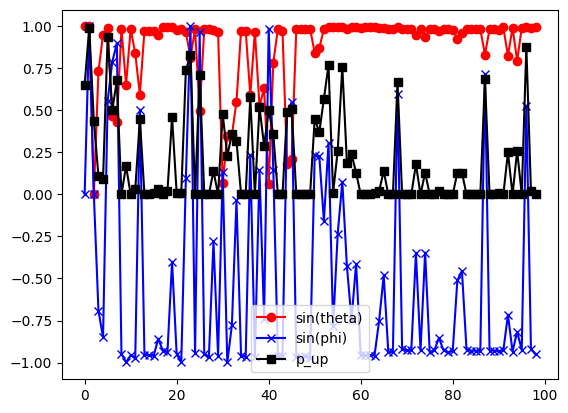

In [5]:
plt.plot(np.sin(X[1,:,0]),'o-r',label='sin(theta)')
plt.plot(np.sin(X[1,:,1]),'x-b',label='sin(phi)')
plt.plot(X[1,:,2],'s-k',label='p_up')
plt.legend()
plt.show()

In [6]:
# Set the percentage of data to use for validation
validation_split = 0.2

# Determine the number of samples to use for validation
num_validation_samples = int(angles_data.shape[0] * validation_split)

# Split the data into training and validation sets
train_data_angles  = angles_data[:-num_validation_samples]
train_data_banks   = banks_data[:-num_validation_samples]
train_data_weights = weights_data[:-num_validation_samples]

validation_data_angles  = angles_data[-num_validation_samples:]
validation_data_banks   = banks_data[-num_validation_samples:]
validation_data_weights = weights_data[-num_validation_samples:]

In [7]:
# Set batch size
batch_size = 32

# TensorFlow datasets API
train_dataset      = tf.data.Dataset.from_tensor_slices((train_data_angles, train_data_banks, train_data_weights)).batch(batch_size)
validation_dataset = tf.data.Dataset.from_tensor_slices((validation_data_angles, validation_data_banks, validation_data_weights)).batch(batch_size)


In [39]:
d_model   = 64  # Adjust this according to our needs
num_heads = 4   # Adjust this according to our needs
# Permutation Invariance
class PermutationInvariantLayer(tf.keras.Model):
    def __init__(self, d_model, num_heads):
        super(PermutationInvariantLayer, self).__init__()

        # Ensure d_model is divisible by num_heads
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=d_model // num_heads
        )
        self.pooling = layers.GlobalAveragePooling1D()

    def call(self, inputs, training=None, mask=None):
        attention_output = self.attention(inputs, inputs)
        pooled_output = self.pooling(attention_output)
        return pooled_output
'''
# Permutation Invariance
class PermutationInvariantLayer(tf.keras.Model):
    def __init__(self):
        super(PermutationInvariantLayer, self).__init__()

        # Ensure d_model is divisible by num_heads
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

        self.attention = layers.MultiHeadAttention(
              num_heads=num_heads, key_dim=d_model // num_heads
            )
        self.pooling = layers.GlobalAveragePooling1D()

    def call(self, inputs, training=None, mask=None):
        attention_output = self.attention(inputs, inputs)
        pooled_output    = self.pooling(attention_output)
        return pooled_output
'''

'        \n# Permutation Invariance\nclass PermutationInvariantLayer(tf.keras.Model):\n    def __init__(self):\n        super(PermutationInvariantLayer, self).__init__()\n\n        # Ensure d_model is divisible by num_heads\n        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"\n\n        self.attention = layers.MultiHeadAttention(\n              num_heads=num_heads, key_dim=d_model // num_heads\n            )\n        self.pooling = layers.GlobalAveragePooling1D()\n\n    def call(self, inputs, training=None, mask=None):\n        attention_output = self.attention(inputs, inputs)\n        pooled_output    = self.pooling(attention_output)\n        return pooled_output\n'

In [9]:
class InfoGain_vectorized:
    """
    Class for computing information gain based on angles, bank particles, and weights.
    """
    def information_gain(self, angles, bank_particles, weights):
        """
        Computes information gain given angles, bank particles, and weights.

        Parameters:
        - angles: List of angles [theta, phi].
        - bank_particles: Bank particles.
        - weights: Weights.

        Returns:
        - Information gain.
        """

        angle_dict = {
              "theta": angles[0],
              "phi": angles[1]
          }
        best_guess = np.array(np.einsum('i...,i', bank_particles, weights))
        return self.adaptive_cost_func(angle_dict, bank_particles, weights, best_guess, 1)


    def adaptive_cost_func(self, angles, rhoBank, weights, bestGuess, nQubits):
        meshState = self.angles_to_state_vector(angles, nQubits)
        out = np.einsum('ij,ik->ijk', meshState, meshState.conj())
        K = self.Shannon_entropy(np.einsum('ijk,kj->i', out, bestGuess))
        J = self.Shannon_entropy(np.einsum('ijk,lkj->il', out, rhoBank))
        return np.real(K - np.dot(J, weights))

    def Shannon_entropy(self, prob):
        return np.real(np.sum(-(prob * np.log2(prob)), axis=0))

    def angles_to_state_vector(self, angles, nQubits):
        if nQubits == 1:
            tempMesh = np.array([np.cos(angles["theta"] / 2), np.exp(1j * angles["phi"]) * np.sin(angles["theta"] / 2)])
            meshState = np.array([tempMesh, self.get_opposing_state(tempMesh)])
        else:
            tempMeshA = np.array([np.cos(angles["thetaA"] / 2), np.exp(1j * angles["phiA"]) * np.sin(angles["thetaA"] / 2)])
            tempMeshB = np.array([np.cos(angles["thetaB"] / 2), np.exp(1j * angles["phiB"]) * np.sin(angles["thetaB"] / 2)])
            meshA = np.array([tempMeshA, self.get_opposing_state(tempMeshA)])
            meshB = np.array([tempMeshB, self.get_opposing_state(tempMeshB)])
            meshState = np.array([
                np.kron(meshA[0], meshB[0]),
                np.kron(meshA[0], meshB[1]),
                np.kron(meshA[1], meshB[0]),
                np.kron(meshA[1], meshB[1])
            ], dtype=complex)
        return meshState

    def get_opposing_state(self, meshState):
        if meshState[1] == 0:
            return np.array([0, 1], dtype=complex)

        a = 1
        b = -np.conjugate(meshState[0]) / np.conjugate(meshState[1])
        norm = np.sqrt(a * np.conjugate(a) + b * np.conjugate(b))
        oppositeMeshState = np.array([a / norm, b / norm], dtype=complex)
        return oppositeMeshState


In [10]:
def custom_loss_function(y_true, y_pred, bank_particles_value, weights_value, lambda_weight=1.0):
    y_true_values = y_true[:, :2]
    y_pred_values = y_pred

    info_gain = InfoGain_vectorized()

    #mse_target = tf.keras.losses.mean_squared_error(y_true_values, y_pred_values)
    mse_target = tf.reduce_mean(tf.keras.losses.mean_squared_error(y_true_values, y_pred_values))


    true_info_gains = np.array([
        info_gain.information_gain(y_true_val, bank_particles_val, weights_val)
        for y_true_val, bank_particles_val, weights_val in zip(y_true_values.numpy(), bank_particles_value, weights_value)
    ])

    predict_info_gains = np.array([
        info_gain.information_gain(y_pred_val, bank_particles_val, weights_val)
        for y_pred_val, bank_particles_val, weights_val in zip(y_pred_values.numpy(), bank_particles_value, weights_value)
    ])

    loss_components = 1 - (predict_info_gains / true_info_gains)
    loss_infoGain = tf.convert_to_tensor(loss_components, dtype=tf.float32)

    total_loss = mse_target + lambda_weight * tf.reduce_mean(loss_infoGain)

    return total_loss


In [12]:
def custom_accuracy(y_true, y_pred):
    y_true_values = y_true[:, :2]
    y_pred_values = y_pred

    #  Mean Absolute Error
    mae = tf.reduce_mean(tf.abs(y_true_values - y_pred_values))
    return mae

In [25]:
model = tf.keras.models.Sequential([
    #PermutationInvariantLayer(),  # Add the PermutationInvariantLayer as the first layer
    tf.keras.layers.Dense(64, activation='relu', input_shape=(None, 3)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(2, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss=custom_loss_function, metrics=[custom_accuracy])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, None, 64)          256       
                                                                 
 dense_13 (Dense)            (None, None, 32)          2080      
                                                                 
 dense_14 (Dense)            (None, None, 2)           66        
                                                                 
Total params: 2402 (9.38 KB)
Trainable params: 2402 (9.38 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [29]:
# Create a small test dataset
test_data = np.random.rand(32, 10, 3)  # Assuming batch=32, sequence length=10, features=3

# Convert the data to TensorFlow tensors
test_data_tf = tf.constant(test_data, dtype=tf.float32)

# Run the model on the test data
predictions = model.predict(test_data_tf)

# Print input and output shapes for verification
print("Input Shape:", test_data.shape)
print("Output Shape:", predictions.shape)


1/1 [==============================] - 0s 82ms/step
Input Shape: (32, 10, 3)
Output Shape: (32, 10, 2)


In [36]:
# Define the model with MultiHeadAttention using functional API
inputs           = tf.keras.Input(shape=(None, 3))
x                = tf.keras.layers.Dense(64, activation='relu')(inputs)
attention_output = tf.keras.layers.MultiHeadAttention(num_heads=4, key_dim=16)(x, x, x)  # Self-attention
x                = tf.keras.layers.GlobalAveragePooling1D()(attention_output)
x                = tf.keras.layers.Dense(32, activation='relu')(x)
outputs          = tf.keras.layers.Dense(2, activation='sigmoid')(x)

model2 = tf.keras.Model(inputs=inputs, outputs=outputs)

model2.compile(optimizer='adam', loss=custom_loss_function, metrics=[custom_accuracy])

model2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, 3)]            0         []                            
                                                                                                  
 dense_27 (Dense)            (None, None, 64)             256       ['input_1[0][0]']             
                                                                                                  
 multi_head_attention_3 (Mu  (None, None, 64)             16640     ['dense_27[0][0]',            
 ltiHeadAttention)                                                   'dense_27[0][0]',            
                                                                     'dense_27[0][0]']            
                                                                                              

In [37]:
# Create a small test dataset
test_data = np.random.rand(32, 10, 3)  # Assuming batch=32, sequence length=10, features=3

# Convert the data to TensorFlow tensors
test_data_tf = tf.constant(test_data, dtype=tf.float32)

# Run the model on the test data
predictions = model2.predict(test_data_tf)

# Print input and output shapes for verification
print("Input Shape:", test_data.shape)
print("Output Shape:", predictions.shape)

1/1 [==============================] - 0s 110ms/step
Input Shape: (32, 10, 3)
Output Shape: (32, 2)


In [40]:
model3 = tf.keras.models.Sequential([
    # Other layers before the PermutationInvariantLayer
    layers.Dense(64, activation='relu', input_shape=(None, 3)),
    # ...
    PermutationInvariantLayer(d_model, num_heads),
    # Other layers after the PermutationInvariantLayer
    layers.Dense(32, activation='relu'),
    layers.Dense(2, activation='sigmoid')
])

# Compile the model
model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model3.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_31 (Dense)            (None, None, 64)          256       
                                                                 
 permutation_invariant_laye  (None, 64)                16640     
 r_1 (PermutationInvariantL                                      
 ayer)                                                           
                                                                 
 dense_32 (Dense)            (None, 32)                2080      
                                                                 
 dense_33 (Dense)            (None, 2)                 66        
                                                                 
Total params: 19042 (74.38 KB)
Trainable params: 19042 (74.38 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [41]:
# Create a small test dataset
test_data = np.random.rand(32, 10, 3)  # Assuming batch=32, sequence length=10, features=3

# Convert the data to TensorFlow tensors
test_data_tf = tf.constant(test_data, dtype=tf.float32)

# Run the model on the test data
predictions = model3.predict(test_data_tf)

# Print input and output shapes for verification
print("Input Shape:", test_data.shape)
print("Output Shape:", predictions.shape)

1/1 [==============================] - 0s 154ms/step
Input Shape: (32, 10, 3)
Output Shape: (32, 2)


In [ ]:
# Initialize lists to store training metrics
train_loss_history     = []
val_loss_history       = []
train_accuracy_history = []
val_accuracy_history   = []
epochs                 = 50

In [ ]:
# Training loop
for epoch in range(epochs):
    # Initialize variables to accumulate batch-wise losses and MAE
    total_train_loss     = 0
    total_train_accuracy = 0
    total_val_loss       = 0
    total_val_accuracy   = 0

    # Iterate over batches for training
    for batch_angles, batch_banks, batch_weights in train_dataset:
        with tf.GradientTape() as tape:
            # Separate input (X) and true labels (y)
            X      = batch_angles[:, :, :3]
            y_true = batch_angles[:, :, 3:]

            # Flatten X and y_true for feeding to the model
            X_flat      = tf.reshape(X, [-1, X.shape[-1]])
            y_true_flat = tf.reshape(y_true, [-1, y_true.shape[-1]])

            # Get predictions from the model
            predictions_flat = model(X_flat)

            # Reshape predictions to match the shape of y_true
            predictions = tf.reshape(predictions_flat, y_true.shape)

            # Calculate loss
            loss = custom_loss_function(predictions, y_true, batch_banks, batch_weights)

        gradients = tape.gradient(loss, model.trainable_variables)
        model.optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        total_train_loss += loss.numpy()
        total_train_accuracy += custom_accuracy(y_true, predictions,).numpy()

    # Iterate over batches for validation
    for batch_angles, batch_banks, batch_weights in validation_dataset:
        # Separate input (X) and true labels (y) for validation
        X      = batch_angles[:, :, :3]
        y_true = batch_angles[:, :, 3:]

        # Flatten X and y_true for feeding to the model
        X_flat      = tf.reshape(X, [-1, X.shape[-1]])
        y_true_flat = tf.reshape(y_true, [-1, y_true.shape[-1]])

        # Get predictions from the model
        predictions_flat = model(X_flat)

        # Reshape predictions to match the shape of y_true
        predictions = tf.reshape(predictions_flat, y_true.shape)

        # Calculate loss
        loss = custom_loss_function(predictions, y_true, batch_banks, batch_weights)

        total_val_loss += loss.numpy()
        total_val_accuracy  += custom_accuracy(y_true, predictions).numpy()

    # Average losses and MAE over all batches
    avg_train_loss     = total_train_loss     / len(train_dataset)
    avg_train_accuracy = total_train_accuracy / len(train_dataset)
    avg_val_loss       = total_val_loss       / len(validation_dataset)
    avg_val_accuracy   = total_val_accuracy   / len(validation_dataset)

    # Append metrics to history
    train_loss_history.append(avg_train_loss)
    train_accuracy_history.append(avg_train_accuracy)
    val_loss_history.append(avg_val_loss)
    val_accuracye_history.append(avg_val_accuracy)

    print(f'Epoch {epoch + 1}/{epochs}, '
          f'Training Loss: {avg_train_loss:.4f}, Training Accuracy: {avg_train_accuracy:.4f}, '
          f'Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {avg_val_accuracy:.4f}')


In [ ]:
# Plot the training history
plt.figure(figsize=(6, 5))
plt.plot(train_loss_history)
plt.plot(val_loss_history)
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
# Plot the training history
plt.figure(figsize=(6, 5))
plt.plot(train_accuracy_history)
plt.plot(val_accuracy_history)
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()